<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>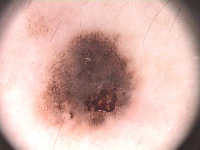</td><td>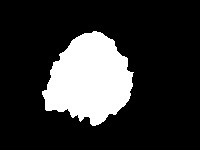</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# !wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [ ]:
# !ls

In [ ]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
# root = 'PH2Dataset'
root = '../input/ph2dataset/PH2Dataset/'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

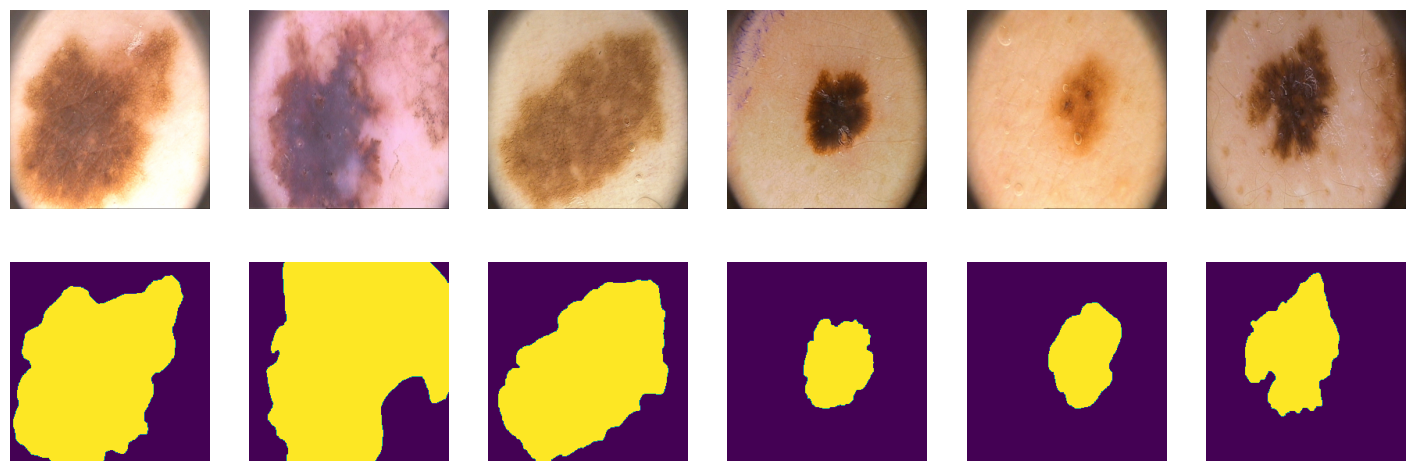

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

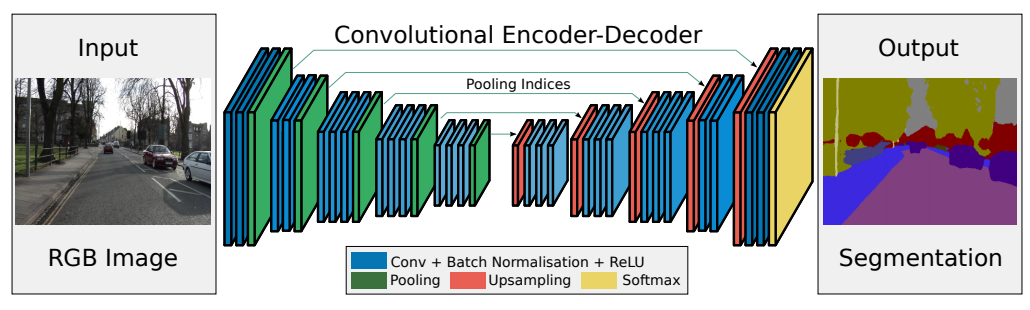

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
# !pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torchsummary import summary
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
# посмотрим как выглядит vgg 16, т.к. сеть encoder-а в SegNet топологически
# идентична сверточным слоям в VGG16
models.vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class SegNet(nn.Module):
    def encoder(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def decoder(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(self.encoder(3, 64),
                                       self.encoder(64, 64))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(self.encoder(64, 128),
                                       self.encoder(128, 128))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(self.encoder(128, 256),
                                       self.encoder(256, 256),
                                       self.encoder(256, 256))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(self.encoder(256, 512),
                                       self.encoder(512, 512),
                                       self.encoder(512, 512))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck возможно не обязателен
        self.enc_conv_bn = nn.Sequential(self.encoder(512, 512),
                                         self.encoder(512, 512),
                                         self.encoder(512, 512))
        self.pool_bottleneck = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
        self.upsample_bottleneck = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.decoder_conv_bn = nn.Sequential(self.decoder(512, 512),
                                         self.decoder(512, 512),
                                         self.decoder(512, 512))

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(self.decoder(512, 512),
                                       self.decoder(512, 512),
                                       self.decoder(512, 256))
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(self.decoder(256, 256),
                                       self.decoder(256, 256),
                                       self.decoder(256, 128))
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(self.decoder(128, 128),
                                       self.decoder(128, 64))
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self.decoder(64, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), padding=(1, 1)),
       )

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        pool_b, idx_bottleneck = self.pool_bottleneck(self.enc_conv_bn(e3))
        bottleneck = self.decoder_conv_bn(self.upsample_bottleneck(pool_b, idx_bottleneck))

        # decoder
        d0 = self.dec_conv0(self.upsample0(bottleneck, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0)) # no activation
        return d3

In [ ]:
SegNet()

SegNet(
  (enc_conv0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    epsilon = 1e-8
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1)
    result = - torch.mean(
        y_real * torch.log(torch.sigmoid(y_pred) + epsilon) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + epsilon)
    )
    return result

In [ ]:
# Проверим что функция работает
loss = torch.nn.BCEWithLogitsLoss()
bce_loss(torch.randn(35,14,225,1), torch.randn(35,14,225,1)),\
loss(torch.randn(35,14,225,1), torch.randn(35,14,225,1)),\

(tensor(0.8083), tensor(0.8040))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
# Создадим словарь для хранения результатов
res = {"segnet": {}, "unet":{}, "unet2":{}}
for key in res:
    res[key] = {"bce":[], "dice":[], "focal":[], "soft_bce":[]}

res

{'segnet': {'bce': [], 'dice': [], 'focal': [], 'soft_bce': []},
 'unet': {'bce': [], 'dice': [], 'focal': [], 'soft_bce': []},
 'unet2': {'bce': [], 'dice': [], 'focal': [], 'soft_bce': []}}

In [ ]:
def plot_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(history['epoch'], history['train_loss'], label='train_loss')
    axes[0].plot(history['epoch'], history['val_loss'], label='val_loss')
    axes[1].plot(history['epoch'], history['val_score'], label='val_score')
    for i in [0,1]: axes[i].legend()

def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler= None):

    X_val, Y_val = next(iter(data_val))

    losses = []
    metric = []

    history = {'epoch':[],'train_loss':[], 'train_score':[], 'val_loss':[],'val_score':[]}

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        train_acc = score_model(model, iou_pytorch, data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        losses.append(avg_loss.item())
        metric.append(score_model(model, iou_pytorch, data_val))

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu

        val_score = iou_pytorch(Y_val, Y_hat > 0.5).mean()
        val_loss = loss_fn(Y_val, Y_hat)
        val_acc = score_model(model, iou_pytorch, data_val)

        history['epoch'].append(epoch)
        history['train_loss'].append(avg_loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_score'].append(val_score.item())

        if scheduler is not None:
            print(scheduler.get_last_lr())
            scheduler.step()

        print('train_loss', avg_loss, 'val_loss', val_loss, 'train_acc', train_acc, 'val_acc', val_acc)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    torch.cuda.empty_cache()
    plot_history(history)
    return losses, metric, history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = (model(X_batch.to(device)) > 0.5).int()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
max_epochs = 60

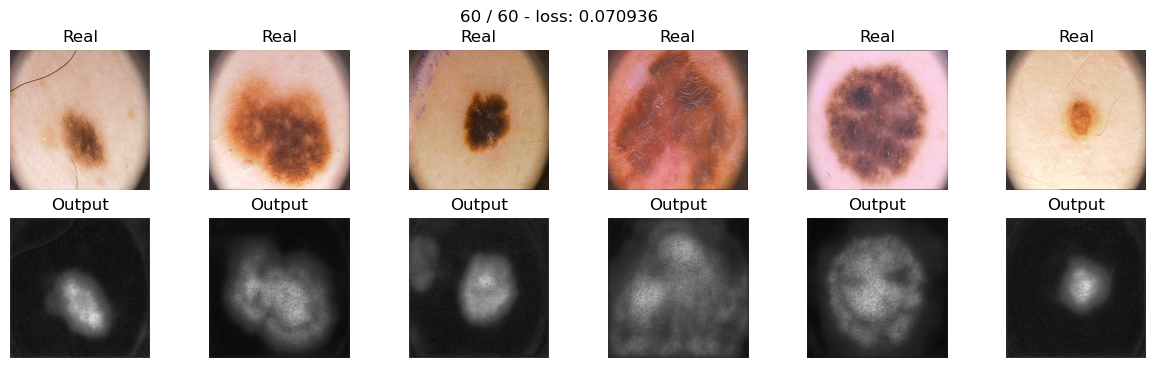

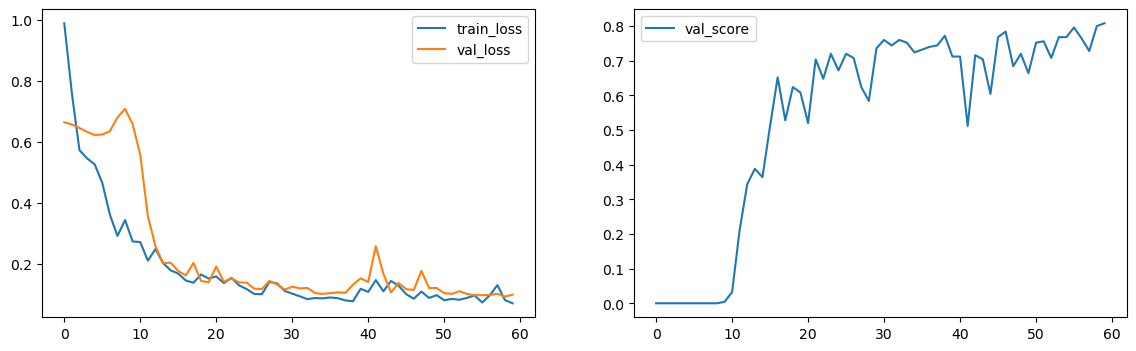

In [ ]:
model = SegNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)
res["segnet"]["bce"] = res_

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7559999823570251

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
 def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    outputs = torch.sigmoid(y_pred)
    num = 2 * (outputs * y_real).sum()
    den = (outputs + y_real).sum()
    res = 1 - (num + SMOOTH) / (den + SMOOTH)
    return res

Проводим тестирование:

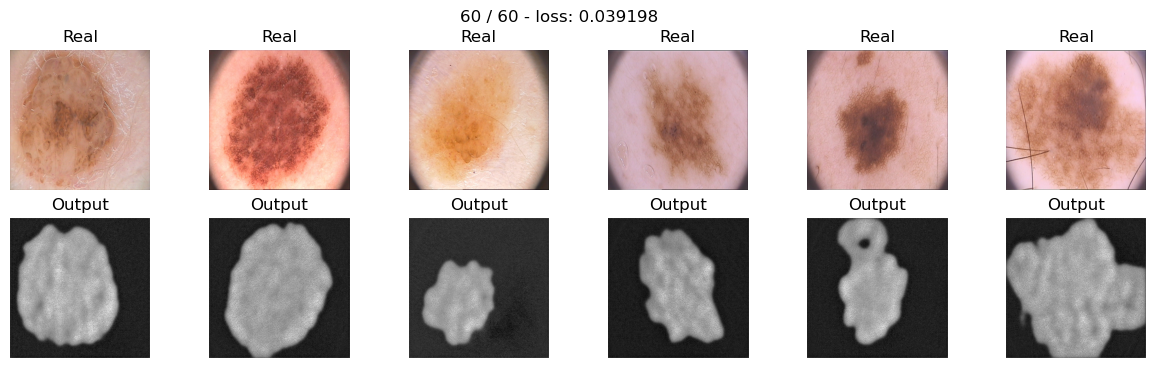

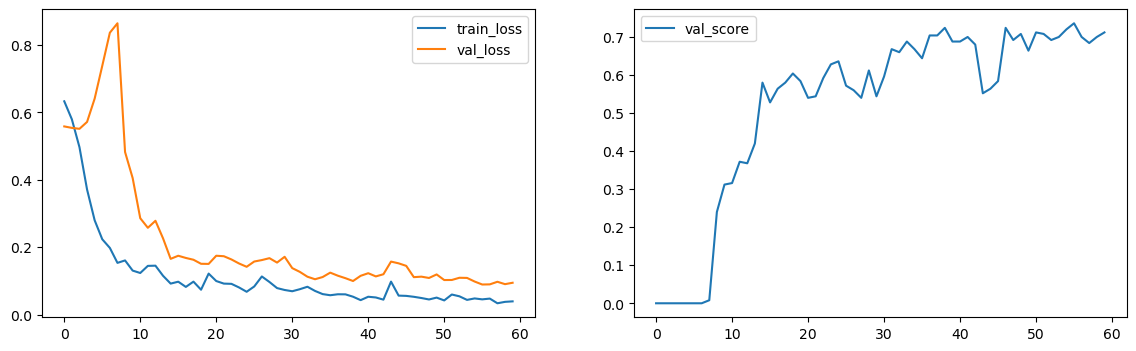

In [ ]:
torch.cuda.empty_cache()

model_dice = SegNet().to(device)
optimizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)
res["segnet"]["dice"] = res_

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7720000147819519

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, gamma = 2):
    y_pred =  (torch.sigmoid(y_pred)).view(-1)
    y_real = y_real.view(-1)
    bce_loss = F.binary_cross_entropy(y_pred, y_real, reduction='mean')
    exponen_bce = torch.exp(-bce_loss)
    your_loss = (1-exponen_bce)**gamma * bce_loss
    return your_loss

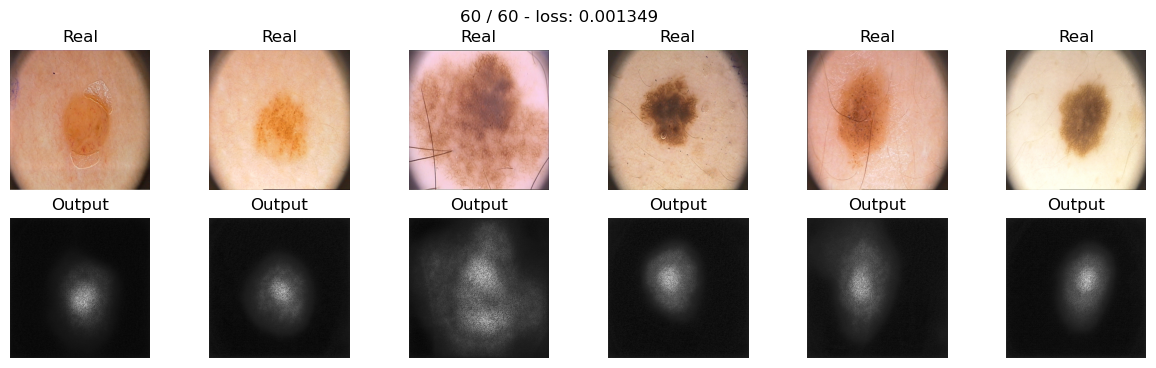

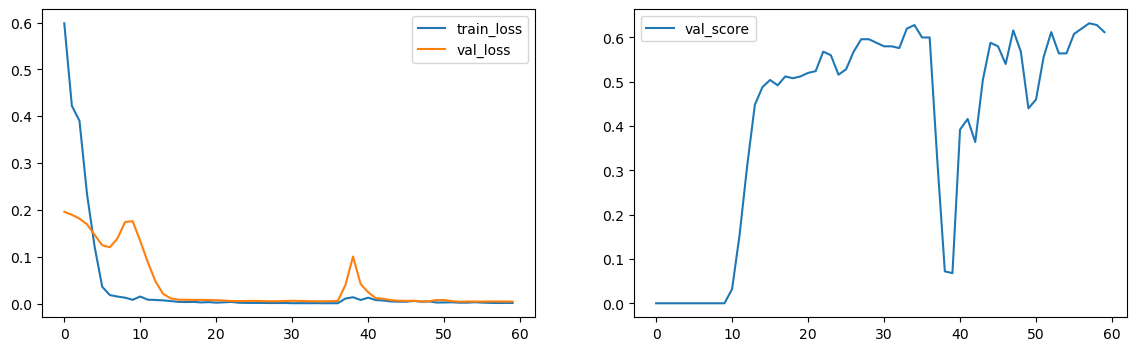

In [ ]:
torch.cuda.empty_cache()

model_focal = SegNet().to(device)
optimaizer = optim.Adam(model_focal.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)
res["segnet"]["focal"] = res_

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.6479999721050262

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
# 3) реализуем BCE но с Soft Targets

class SoftBCEWithLogitsLoss(nn.Module):
    def __init__(self, smooth_factor=None):
        super().__init__()

        self.smooth_factor = smooth_factor

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        if self.smooth_factor is not None:
            soft_targets = ((1 - target) * self.smooth_factor +
                            target * (1 - self.smooth_factor)).type_as(input)
        else:
            soft_targets = target.type_as(input)

        loss = bce_loss(input, target)

        return loss

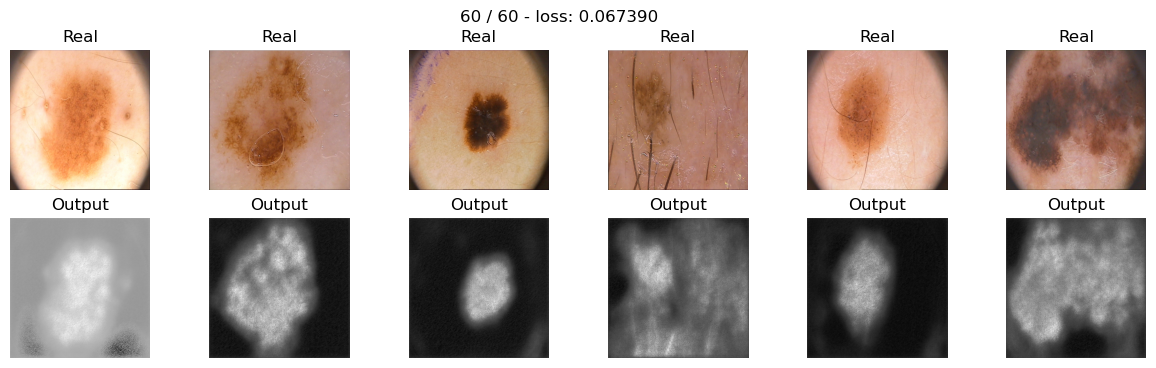

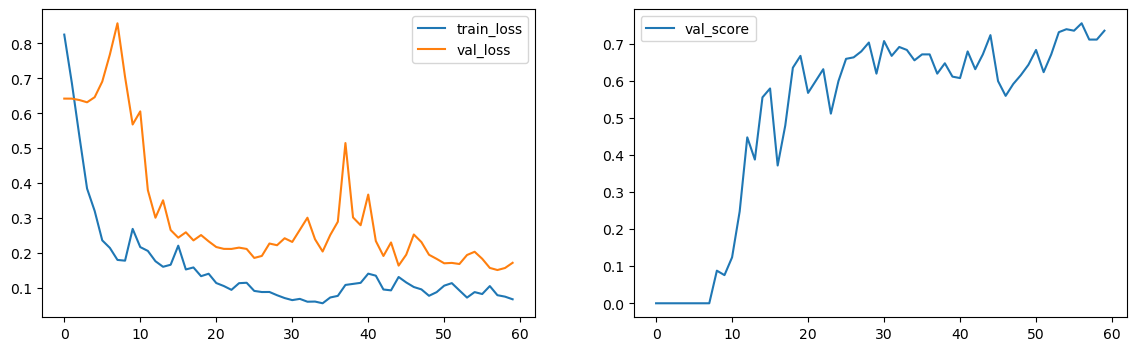

In [ ]:
torch.cuda.empty_cache()

model_soft_bce = SegNet().to(device)
optimaizer = optim.Adam(model_soft_bce.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(model_soft_bce, optimaizer, SoftBCEWithLogitsLoss(smooth_factor=0.1), max_epochs, data_tr, data_val)
res["segnet"]["soft_bce"] = res_

In [ ]:
score_model(model_soft_bce, iou_pytorch, data_val)

0.7559999823570251

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

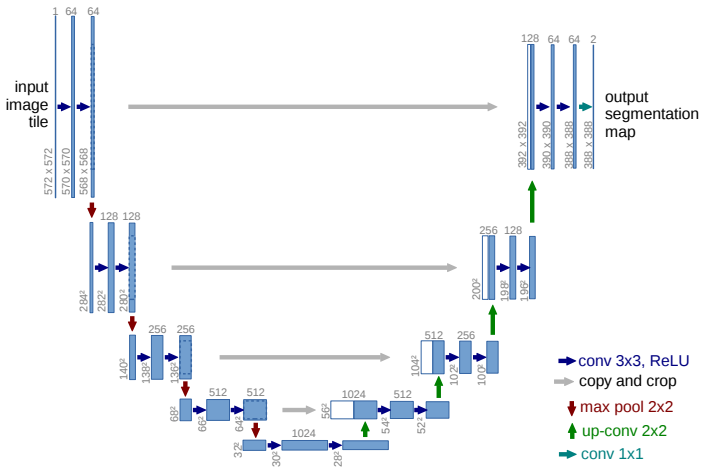

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):

    def encod_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def encod_pool_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.encod_conv(in_channels, out_channels)
        )

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = self.encod_conv(3,64) # 256 -> 128
        self.enc_conv1 = self.encod_pool_conv(64, 128) # 128 -> 64
        self.enc_conv2 = self.encod_pool_conv(128, 256) # 64 -> 32
        self.enc_conv3 = self.encod_pool_conv(256, 512)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = self.encod_conv(2 * 512, 256)
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = self.encod_conv(2 * 256, 128)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = self.encod_conv(2 * 128, 64)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self.encod_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(p3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [ ]:
UNet()

UNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc_conv1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc_conv2): Sequential(
    (0): M

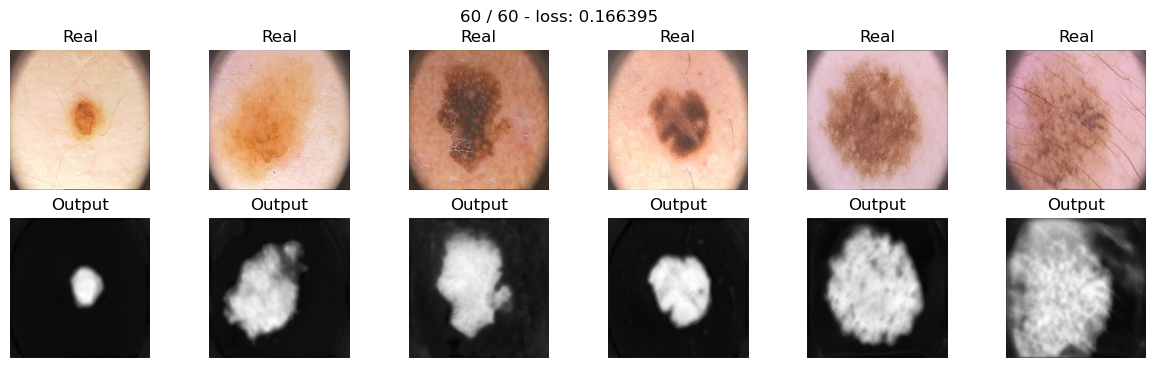

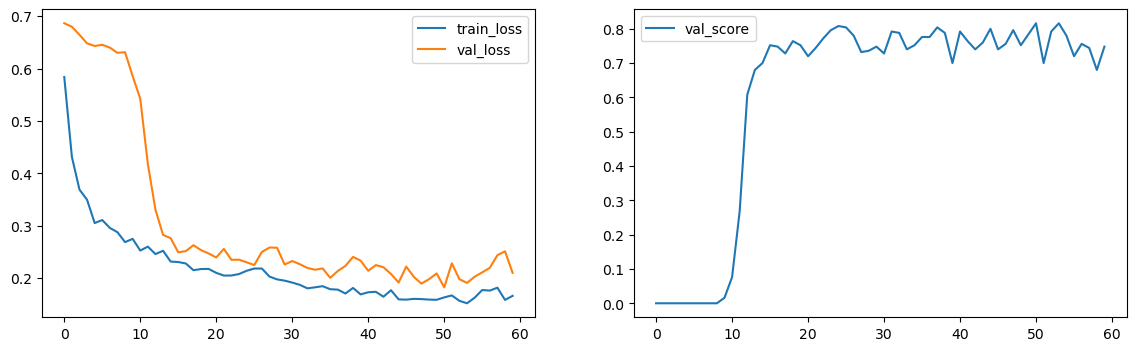

In [ ]:
torch.cuda.empty_cache()

unet_model = UNet().to(device)
optimaizer = optim.Adam(unet_model.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
res["unet"]["bce"] = res_

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.706000030040741

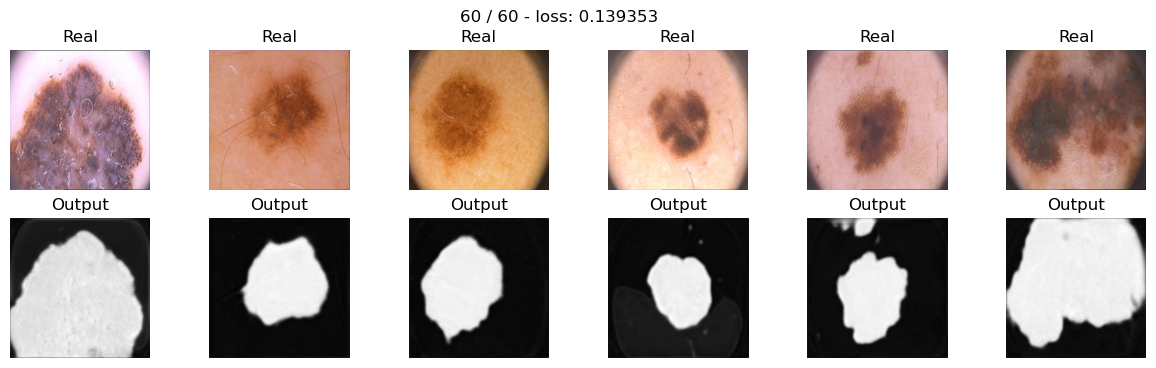

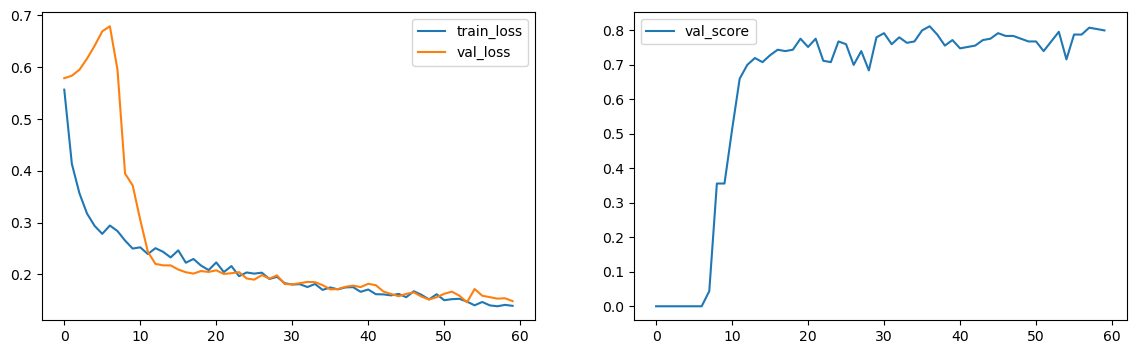

In [ ]:
torch.cuda.empty_cache()

unet_model_dice = UNet().to(device)
optimaizer = optim.Adam(unet_model_dice.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet_model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
res["unet"]["dice"] = res_

In [ ]:
score_model(unet_model_dice, iou_pytorch, data_val)

0.8119999766349792

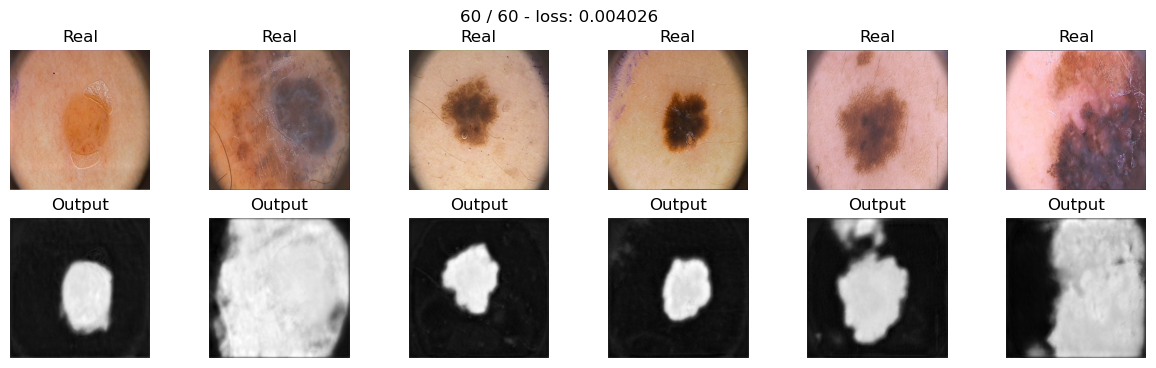

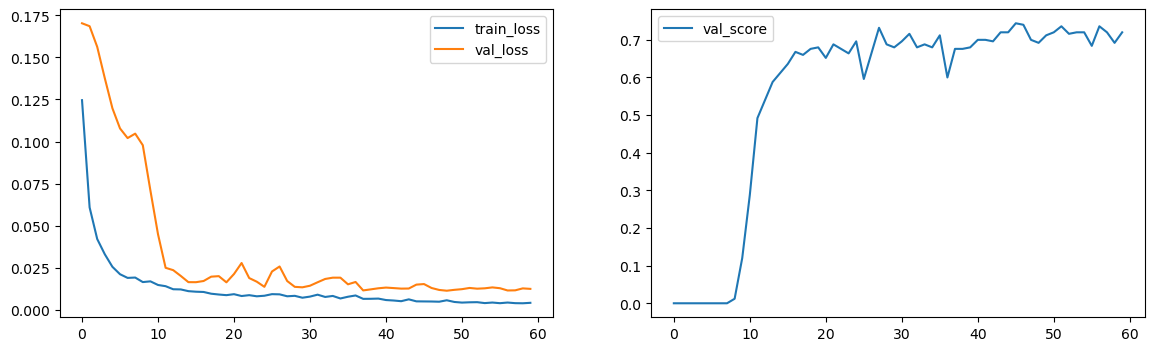

In [ ]:
torch.cuda.empty_cache()

unet_model_focal = UNet().to(device)
optimaizer = optim.Adam(unet_model_focal.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet_model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)
res["unet"]["focal"] = res_

In [ ]:
score_model(unet_model_focal, iou_pytorch, data_val)

0.7820000052452087

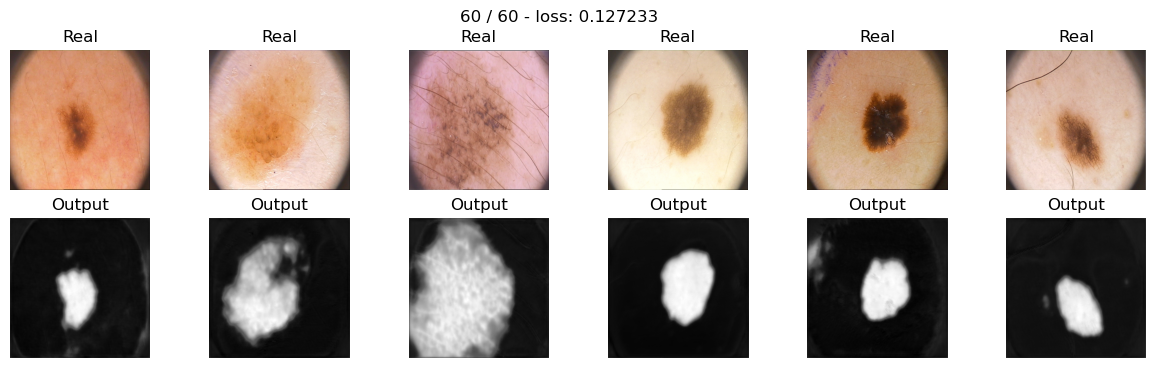

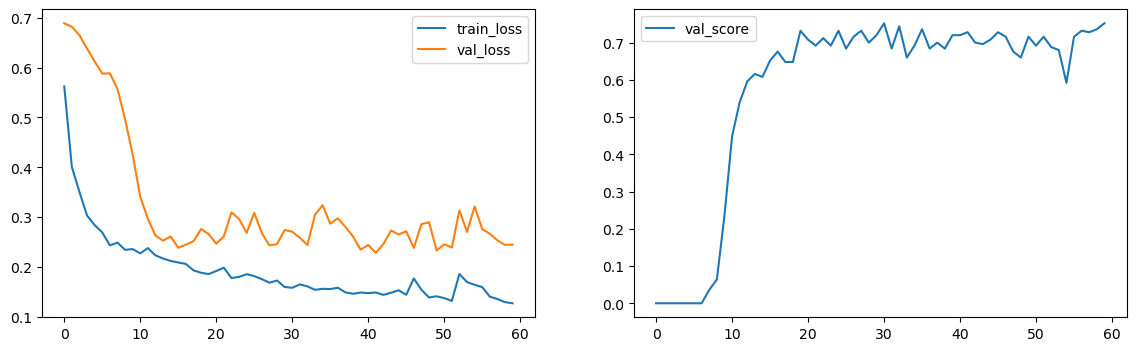

In [ ]:
torch.cuda.empty_cache()

unet_model_soft_bce = UNet().to(device)
optimaizer = optim.Adam(unet_model_soft_bce.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet_model_soft_bce, optimaizer, SoftBCEWithLogitsLoss(smooth_factor=0.1), max_epochs, data_tr, data_val)
res["unet"]["soft_bce"] = res_

In [ ]:
score_model(unet_model_soft_bce, iou_pytorch, data_val)

0.7820000350475311

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):

    def encod_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def encod_pool_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1),
            self.encod_conv(in_channels, out_channels)
        )

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = self.encod_conv(3,64) # 256 -> 128
        self.enc_conv1 = self.encod_pool_conv(64, 128) # 128 -> 64
        self.enc_conv2 = self.encod_pool_conv(128, 256) # 64 -> 32
        self.enc_conv3 = self.encod_pool_conv(256, 512)
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        #self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec_conv0 = self.encod_conv(2 * 512, 256)
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = self.encod_conv(2 * 256, 128)
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = self.encod_conv(2 * 128, 64)
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self.encod_conv(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(p3))

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [ ]:
UNet2()

UNet2(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc_conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc_conv2): Sequential(
    (0): Conv2d(12

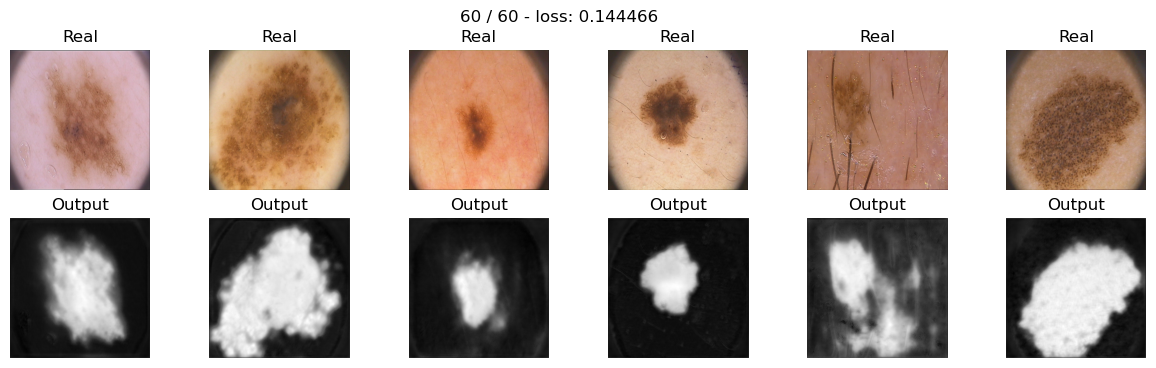

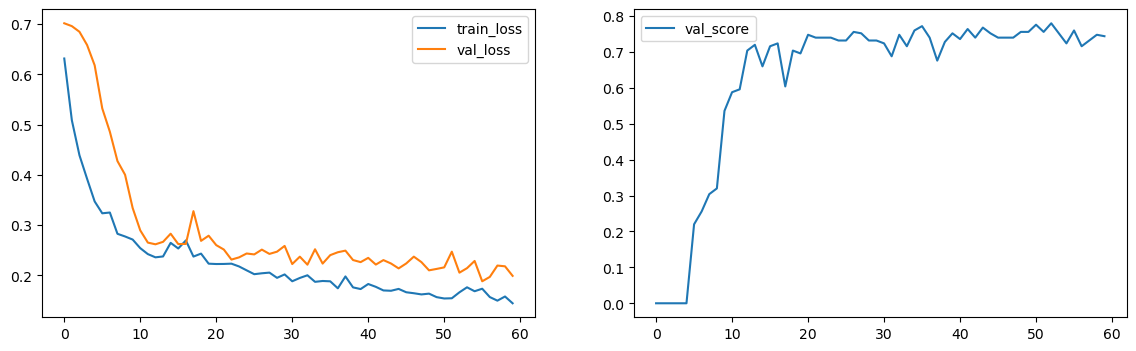

In [ ]:
torch.cuda.empty_cache()

unet2_model = UNet2().to(device)
optimaizer = optim.Adam(unet2_model.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)
res["unet2"]["bce"] = res_

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7820000350475311

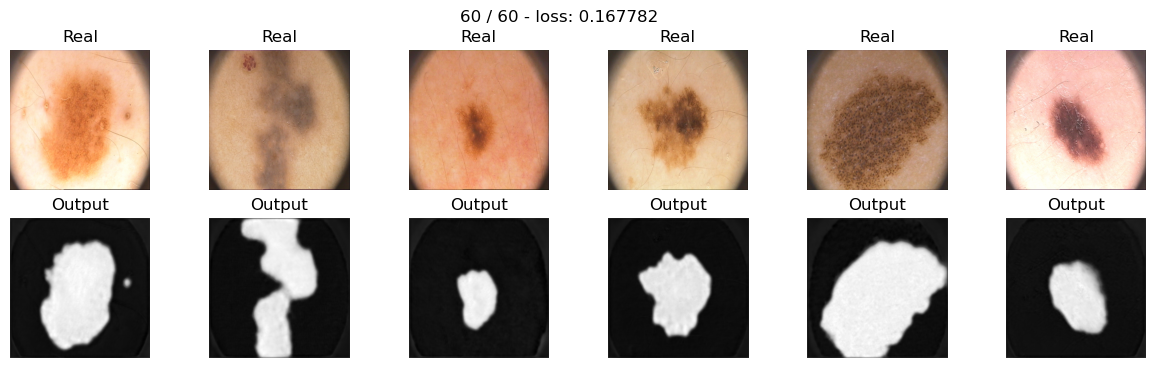

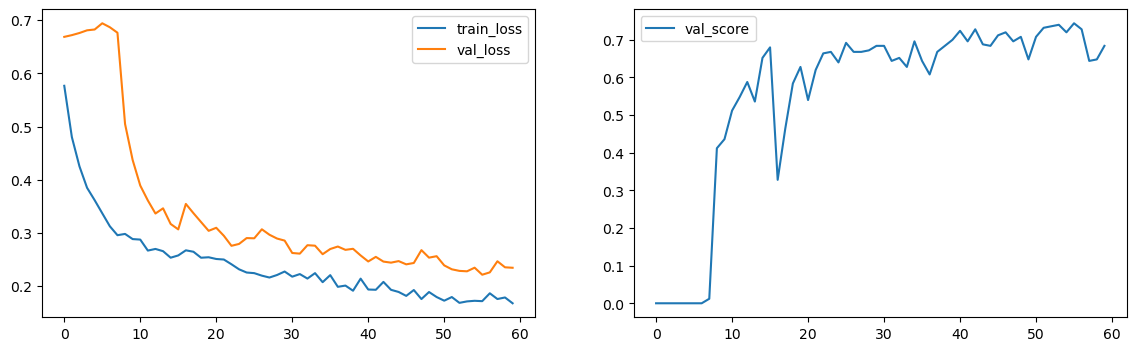

In [ ]:
torch.cuda.empty_cache()

unet2_model_dice = UNet2().to(device)
optimaizer = optim.Adam(unet2_model_dice.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet2_model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)
res["unet2"]["dice"] = res_

In [ ]:
score_model(unet2_model_dice, iou_pytorch, data_val)

0.7420000433921814

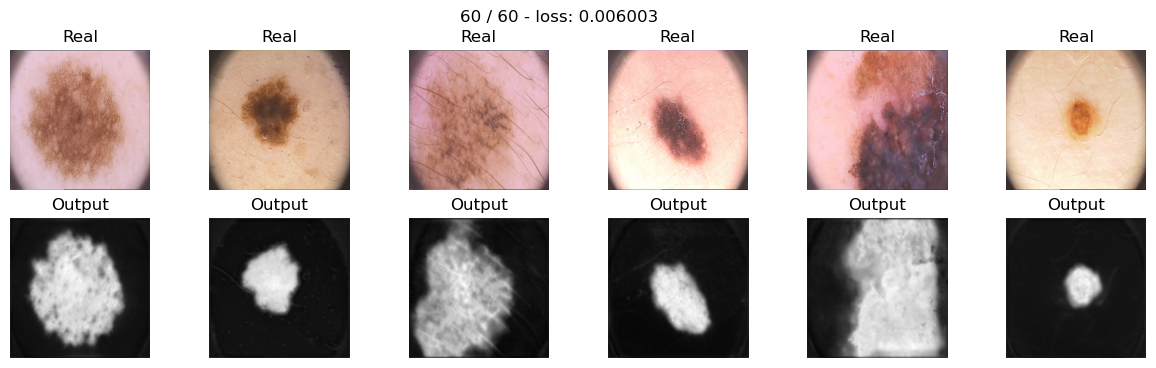

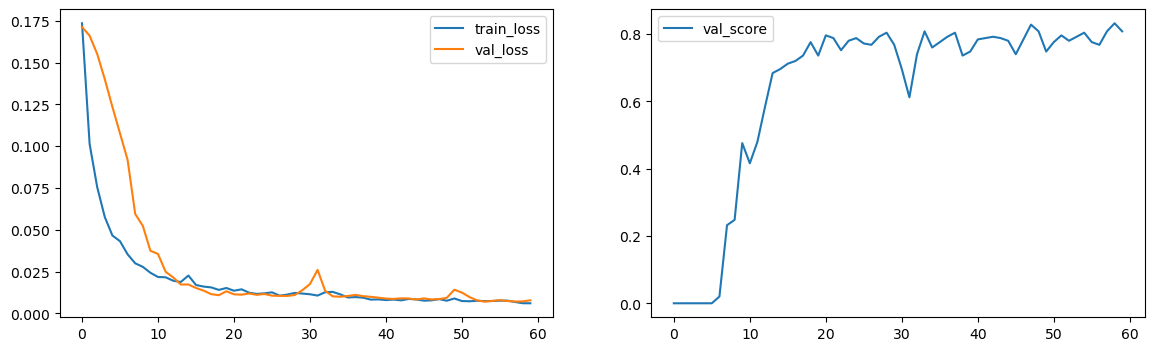

In [ ]:
torch.cuda.empty_cache()

unet2_model_focal = UNet2().to(device)
optimaizer = optim.Adam(unet2_model_focal.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet2_model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)
res["unet2"]["focal"] = res_

In [ ]:
score_model(unet2_model_focal, iou_pytorch, data_val)

0.7719999551773071

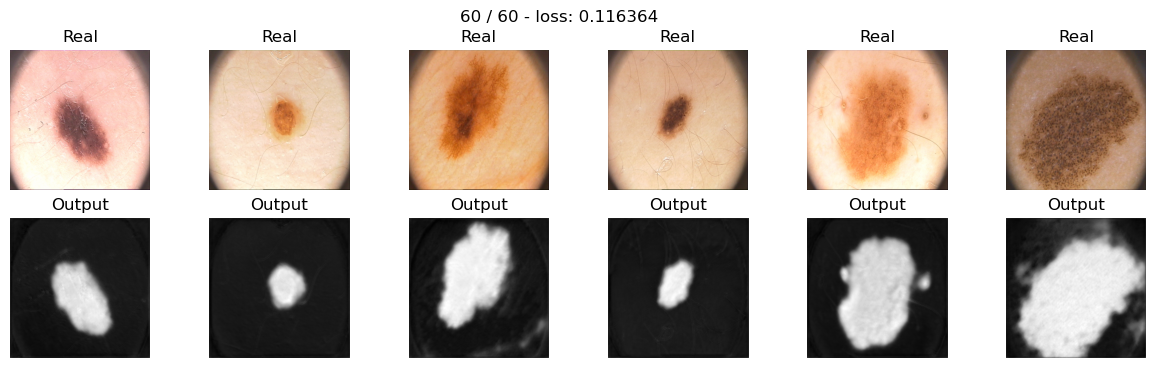

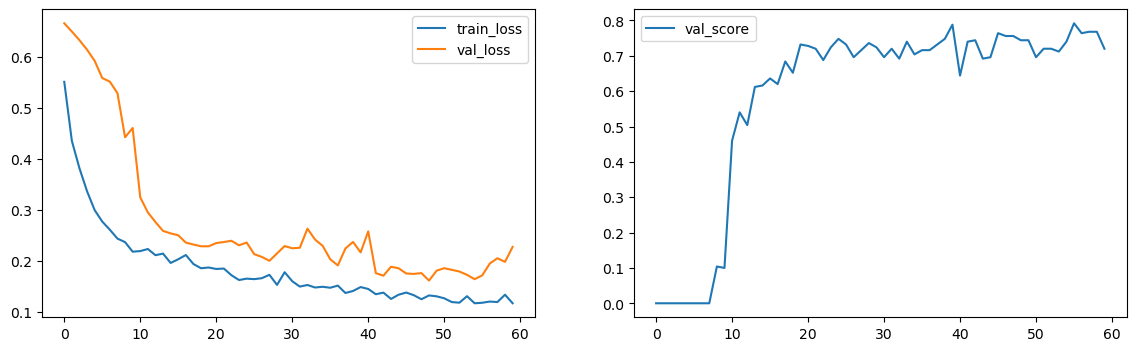

In [ ]:
torch.cuda.empty_cache()

unet2_model_soft_bce = UNet2().to(device)
optimaizer = optim.Adam(unet2_model_soft_bce.parameters(), lr=1e-4)
res_ = [None]*3
res_[0], res_[1], res_[2] = train(unet2_model_soft_bce, optimaizer, SoftBCEWithLogitsLoss(smooth_factor=0.1), max_epochs, data_tr, data_val)
res["unet2"]["soft_bce"] = res_

In [ ]:
score_model(unet2_model_soft_bce, iou_pytorch, data_val)

0.7720000147819519

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Реализовал  три модели SegNet, U-Net, UNet2. Каждую  с четырмя видами функций потерь:  
BCE, DICE,  Focal и SoftBCEWithLogits loss.

In [ ]:
def plot_metrics(model):
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    axes[0].plot(res[model]["bce"][2]['epoch'], res[model]["bce"][2]['val_score'], label=f'{model} BCE')
    axes[0].plot(res[model]["dice"][2]['epoch'], res[model]["dice"][2]['val_score'], label=f'{model} Dice')
    axes[0].plot(res[model]["focal"][2]['epoch'], res[model]["focal"][2]['val_score'], label=f'{model} Focal')
    axes[0].plot(res[model]["soft_bce"][2]['epoch'], res[model]["soft_bce"][2]['val_score'], label=f'{model} SoftBCE')
    axes[0].set_title(f"{model} validation score", fontsize=12)

    axes[1].plot(res[model]["bce"][2]['epoch'], res[model]["bce"][2]['val_loss'], label=f'{model} BCE')
    axes[1].plot(res[model]["dice"][2]['epoch'], res[model]["dice"][2]['val_loss'], label=f'{model} Dice')
    axes[1].plot(res[model]["focal"][2]['epoch'], res[model]["focal"][2]['val_loss'], label=f'{model} Focal')
    axes[1].plot(res[model]["soft_bce"][2]['epoch'], res[model]["soft_bce"][2]['val_loss'], label=f'{model} SoftBCE')
    axes[1].set_title(f"{model} validation loss", fontsize=12)
    for i in [0,1]: axes[i].legend()

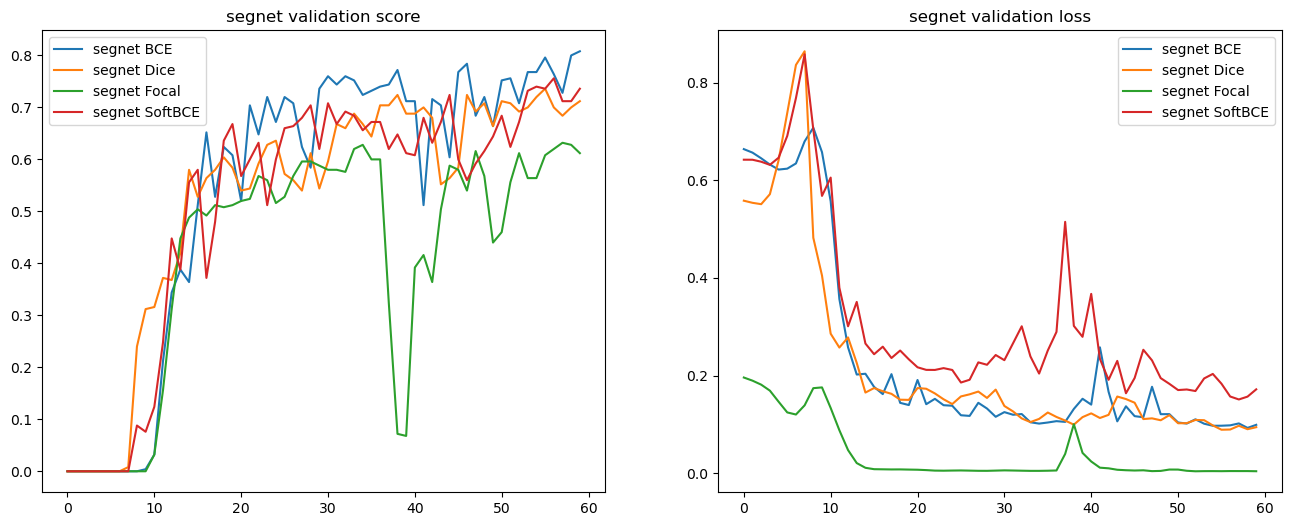

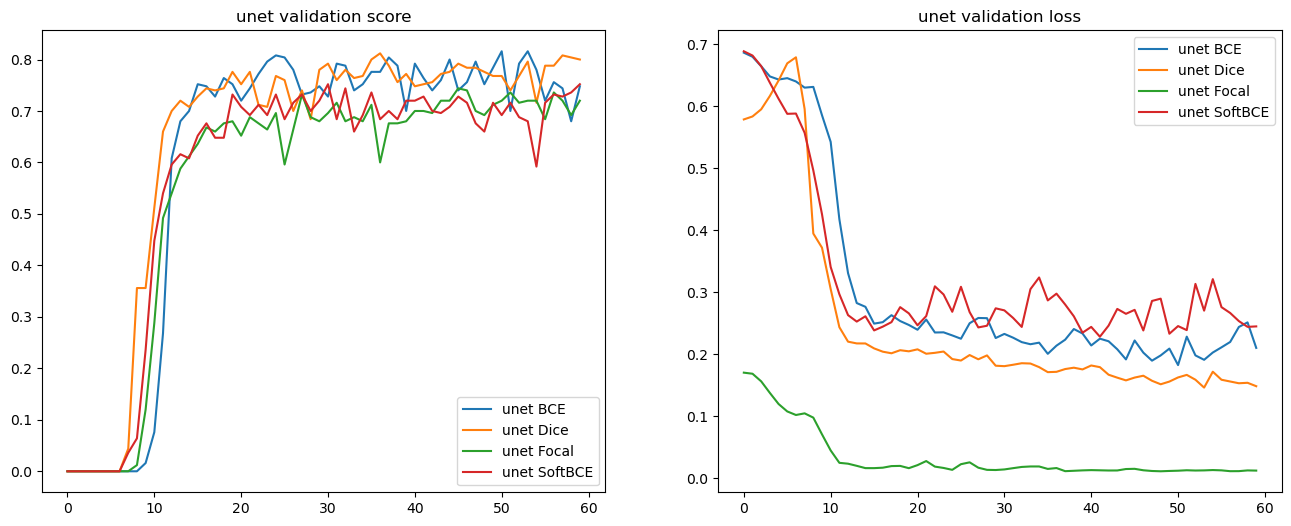

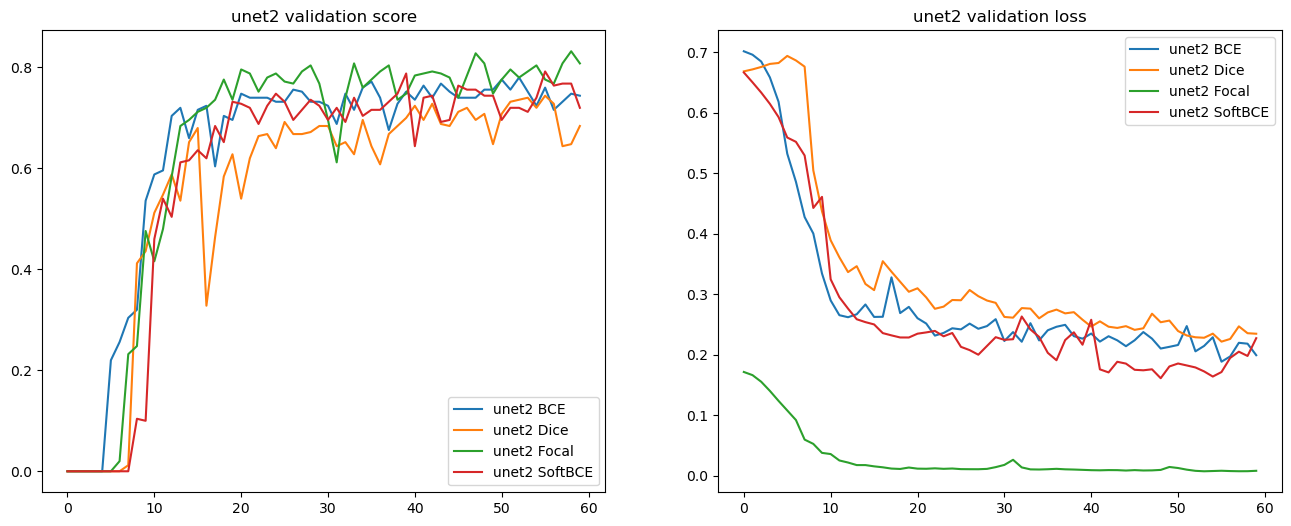

In [ ]:
# Строим графики лоссов, метрик для моделей
plot_metrics("segnet")
plot_metrics("unet")
plot_metrics("unet2")

**Segnet** валидационных данны

In [ ]:
# Segnet score
# Bce, Dice, Focal, Soft Bce
score_model(model, iou_pytorch, data_val),\
score_model(model_dice, iou_pytorch, data_val),\
score_model(model_focal, iou_pytorch, data_val),\
score_model(model_soft_bce, iou_pytorch, data_val)

(0.7559999823570251, 0.7719999551773071, 0.648000031709671, 0.7560000121593475)

**Segnet** на тестовых данных

In [ ]:
# Segnet score
# Bce, Dice, Focal, Soft Bce
score_model(model, iou_pytorch, data_ts),\
score_model(model_dice, iou_pytorch, data_ts),\
score_model(model_focal, iou_pytorch, data_ts),\
score_model(model_soft_bce, iou_pytorch, data_ts)

(0.7519999742507935,
 0.7960000038146973,
 0.6899999678134918,
 0.7339999675750732)

**Unet** валидационных данны

In [ ]:
# Unet score
# Bce, Dice, Focal, Soft Bce
score_model(unet_model, iou_pytorch, data_val),\
score_model(unet_model_dice, iou_pytorch, data_val),\
score_model(unet_model_focal, iou_pytorch, data_val),\
score_model(unet_model_soft_bce, iou_pytorch, data_val)

(0.7060000002384186,
 0.8119999766349792,
 0.7819999754428864,
 0.7820000350475311)

**Unet**   на тестовых данных

In [ ]:
# Unet score
# Bce, Dice, Focal, Soft Bce
score_model(unet_model, iou_pytorch, data_ts),\
score_model(unet_model_dice, iou_pytorch, data_ts),\
score_model(unet_model_focal, iou_pytorch, data_ts),\
score_model(unet_model_soft_bce, iou_pytorch, data_ts)

(0.7319999933242798, 0.8099999725818634, 0.812000036239624, 0.8020000159740448)

**Unet2** валидационных данных

In [ ]:
# Unet2 score
# Bce, Dice, Focal, Soft Bce
score_model(unet2_model, iou_pytorch, data_val),\
score_model(unet2_model_dice, iou_pytorch, data_val),\
score_model(unet2_model_focal, iou_pytorch, data_val),\
score_model(unet2_model_soft_bce, iou_pytorch, data_val)

(0.7819999754428864,
 0.7419999837875366,
 0.7719999849796295,
 0.7720000147819519)

**Unet2**  на тестовых данных

In [ ]:
# Unet2 score
# Bce, Dice, Focal, Soft Bce
score_model(unet2_model, iou_pytorch, data_ts),\
score_model(unet2_model_dice, iou_pytorch, data_ts),\
score_model(unet2_model_focal, iou_pytorch, data_ts),\
score_model(unet2_model_soft_bce, iou_pytorch, data_ts)

(0.7839999794960022, 0.7540000379085541, 0.757999986410141, 0.757999986410141)

Реализованы три модели SegNet, U-Net, UNet2. Каждая протестирована  с четырмя функциями потерь:
BCE, DICE, Focal и SoftBCEWithLogits loss.

Выводы:   
1) Наивысший  score показала модель Unet c функцией потерь DICE на валидационной выборке  и с ф-ей потерь Focal на тестовой.

2) Модель Segnet имеет наилучшее качество с функцией потерь BCE, несмотря на то что итоговый  score выше у Dice.  
На валидации BCE =0.756 Dice=0.771, на тесте BCE =0.751, Dice=0.796.    
По графику Segnet validation score(см. выше ячейка [324]) видно, что у модели с BCE  score  
практически всегда выше score модели  Segnet  с другими функциями потерь.   
Однако нельзя однозначно сказать, что  функция потерь BCE, лучше подходит для обучения модели Segnet.   
Изменение количества эпох, настройка скорости обучения, количества и качества данных и т.д.  могут значительно повлиять  на
итоговый score.  
Так же зависимости не окажутся такими же на отложенной выборке. Т.к. видно, что итоговый score отличается на тестовых и  валидационных выборках. Так для модели Unet  для функций Focal  и  Soft BCE итоговый score оказался выше на  тестовой выборке чем на валидационной  
примерно на 0.02.
3) Для модели Unet  худший результат с функцией  BCE (на тестовой и на валидационной выборке).  

4) Модель Unet2 показывает лучший результат с ф-ей BCE. По графику  validation score видно, что значения BCE, Focal и  Soft BCE к концу обучения находятся примерно на одном уровне. Значение score BCE немного снижается, возможно модель на BCE меньше переобучается  

5) Segnet показывает худший результат с функцией потерь Focal. Значение ф-и потель  Focal примерно на 13 эпохе достигает минимума и практически не меняется.  Но на тестовых данных по сравнению с валидационными данными итоговый score с ф-й потель  Focal увеличивается с  0.648  до 0.689. Вероятно, это связано с тем что модель меньше переобучается, имеея не высокий score.  
Похожая ситуация с  Unet с ф-ей BCE, имея невысокий score на валидационной выборке, его значение увеличивается на тестовой выборке.

6) Нельзя сделать вывод, что какая-то функция потерь работает лучше других. Зависит от модели, процесса обучения и др. факторов.

UNet выигрывает по количеству параметров(см. ниже).

Total params: 18,115,457  
Trainable params: 18,115,457  
Non-trainable params: 0  
----------------------------------------------------------------  
Input size (MB): 18.75  
Forward/backward pass size (MB): 18012.50  
Params size (MB): 69.10  
Estimated Total Size (MB): 18100.35  

**Вывод:**  **UNet** является фаворитом, выигрывает как по количеству параметров и размеру, так в целом и по итоговому результату.
SegNet  проигрывается всем. В целом показывает худшие результаты по итоговому score так и по количеству параметров и размеру.

In [ ]:
from torchsummary import summary

# SegNet
summary(model, input_size=(3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
        MaxPool2d-14  [[

In [ ]:
# UNet
summary(unet_model, input_size=(3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
         MaxPool2d-7         [25, 64, 128, 128]               0
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
        MaxPool2d-14          [25, 128,

In [ ]:
# UNet2
summary(unet2_model, input_size=(3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
            Conv2d-7         [25, 64, 128, 128]          36,928
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
           Conv2d-14          [25, 128,